In [32]:
import pygame
import numpy as np
import random
import matplotlib.pyplot as plt

In [38]:
render = True
unlock_frame_rate = False
opponent = False
frame_rate = 90
fullscreen = False

epsilon = 0
epsilonDecay = 0.9999
discount = 0.95
learning_rate = 0.005

resolution = (640, 360) 

accelerationDecay = 0.9995

max_steps = 10000

pygame.init()

if fullscreen and render:
    info = pygame.display.Info()

    resolution = (info.current_w, info.current_h)

    screen = pygame.display.set_mode(resolution, pygame.FULLSCREEN)
else:

    screen = pygame.display.set_mode(resolution)
clock = pygame.time.Clock()

paddleHeight = 90


ballRad = 10
ball = pygame.Vector2(resolution[0] / 2, resolution[1] / 2)

simpleDifficulty = 2.5

game = 0

number_elements_shown = 50

In [34]:
def discretize(ball_x, ball_y, paddle_y, vel_x, vel_y):
    discrete_x = int(ball_x / resolution[0]) * q_table_shape[0]

    discrete_y = int((ball_y - paddle_y) / resolution[1] * q_table_shape[1])

    disc_ball_y = int(ball_y / resolution[1] * q_table_shape[1])
    disc_pad_y = int(paddle_y / resolution[1] * q_table_shape[1])


    dis_vel_x = int((vel_x + 10) / 20 * q_table_shape[2])
    dis_vel_y = int((vel_y + 10) / 20 * q_table_shape[3])

    return tuple((discrete_x, discrete_y, dis_vel_x, dis_vel_y))

def simpleAI(paddleY, targetY):
    if targetY > paddleY:
        paddleY += simpleDifficulty

    else:
        paddleY -= simpleDifficulty

    return paddleY 

def collision(ball, paddle_rect):
    ball_rect = pygame.Rect(ball.x - ballRad, ball.y - ballRad, ballRad*2, ballRad*2)
    if ball_rect.colliderect(paddle_rect):
        # Collision detected
        return True
    else:
        # No collision detected
        return False

In [35]:
num_actions = 3

q_table_shape = [30, 30, 30, 30]
q_table = np.random.uniform(low = -2, high = 0, size = (q_table_shape + [num_actions]))


In [36]:
rewards_averaged = []
rewards_list = []


In [39]:
while True:
    game += 1

    acceleration = 0.001
    
    paddle1Y = resolution[1] / 2
    paddle2Y = resolution[1] / 2

    gameOver = False
    if opponent:
        initialVel = 4
    else:
        initialVel = random.uniform(4,8)

    randomStart = random.randint(40, 80)
    randomDir = random.randint(0,1)
    if opponent:

        ballPosX = resolution[0] / 2
        ballPosY = resolution[1] / 2
    else:
        ballPosX = random.randint(10, resolution[0] / 2)
        ballPosY = random.randint(10, resolution[1] - 10)
    if randomDir == 0:
        dirMult = 1
    else:
        dirMult = -1
    ballVelX = (randomStart / 100) * initialVel
    ballVelY = (((initialVel ** 2) - (((randomStart / 100) * initialVel)  ** 2))**0.5) * dirMult

    state = discretize(ballPosX, ballPosY, paddle2Y, ballVelX, ballVelY)
    total_reward = 0
    print('Starting Game, ', game)
    steps = 0

    while gameOver != True:
        reward = 0

        # pygame.QUIT event means the user clicked X to close your window
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                gameOver = True

        # fill the screen with a color to wipe away anything from last frame

        paddle1 = pygame.Rect(0.075*resolution[0], paddle1Y - paddleHeight/2, 10, paddleHeight)
        paddle2 = pygame.Rect(0.925*resolution[0], paddle2Y - paddleHeight/2, 10, paddleHeight)

        screen.fill("white")

        pygame.draw.circle(screen, "red", ball, ballRad)
        pygame.draw.rect(screen, 'black', paddle1)
        pygame.draw.rect(screen, 'black', paddle2)

        if opponent:
            if collision(ball, paddle1):
                ballVelX = -ballVelX

        if collision(ball, paddle2):

            if ballVelX > 0:
                ballVelX = -ballVelX
            reward += 1
            if not opponent:
                gameOver = True
                winner = 1

        if ballPosY < ballRad or ballPosY > resolution[1] - ballRad:
            ballVelY = -ballVelY

        if opponent:
            if ballPosX < ballRad:
                winner = 1
                gameOver = True
                reward += 1
                print('CoolAI wins')
                
            elif ballPosX > resolution[0] - ballRad:
                gameOver = True
                winner = 2

                print('BoringAI wins')
        else:

            if ballPosX > resolution[0] - ballRad:
                gameOver = True
                winner = 2
            
        prevHeight = paddle2Y

        ballPosX += ballVelX
        ballPosY += ballVelY

        if opponent:
            paddle1Y = simpleAI(paddle1Y, ballPosY)
        
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, num_actions-1)
        else:
            try:
                action = np.argmax(q_table[state])
            except:
                action = 0        

        if action == 1:
            if paddle2Y > 0:

                paddle2Y -= 5
        elif action == 2:
            if paddle2Y < resolution[1]:

                paddle2Y += 5
        else:
            paddle2Y += 0
            reward += 0.01
        
        new_state = discretize(ballPosX, ballPosY, paddle2Y, ballVelX, ballVelY)
        
        if not gameOver:
            try:
                max_future_q = np.max(q_table[new_state])

                current_q = q_table[state + (action, )]

                new_q = (1 - learning_rate) * current_q + learning_rate * (reward + discount * max_future_q)

                q_table[state + (action, )] = new_q
            except:
                pass
        
        state = new_state

        ball.xy = ballPosX, ballPosY

        if render:
            pygame.display.flip()
        if render and not unlock_frame_rate:
            clock.tick(frame_rate)

        ballVelX = ballVelX + acceleration * ballVelX
        ballVelY = ballVelY + acceleration * ballVelY
        acceleration *= accelerationDecay
        total_reward += reward

    if opponent:
        if winner == 1:
            simpleDifficulty += 0.2
        else:
            if simpleDifficulty > 2:
                simpleDifficulty -= 0.1


        print('The simpleAI difficulty is now:', simpleDifficulty)

    print('The AI scored ', total_reward, 'epsilon is', epsilon)

    rewards_list.append(total_reward)


    epsilon *= epsilonDecay
    steps += 1

pygame.quit()

Starting Game,  1
The AI scored  0.09999999999999999 epsilon is 0
Starting Game,  2
The AI scored  0.5600000000000003 epsilon is 0.0
Starting Game,  3
The AI scored  1.04 epsilon is 0.0
Starting Game,  4
The AI scored  0.09 epsilon is 0.0
Starting Game,  5
The AI scored  1.13 epsilon is 0.0
Starting Game,  6
The AI scored  1.26 epsilon is 0.0
Starting Game,  7


KeyboardInterrupt: 

33
1678


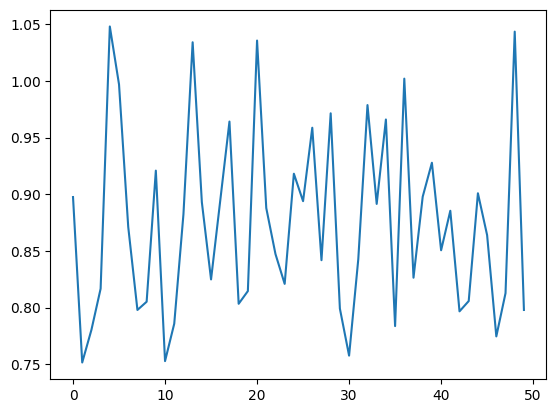

In [ ]:


elements_in_avg = int(len(rewards_list) / number_elements_shown)
print(elements_in_avg)

print(len(rewards_list))

avg_list = []

for average in range(number_elements_shown):
    avg_list.append(np.mean(rewards_list[ average * elements_in_avg : average * elements_in_avg + elements_in_avg ]))
    
plt.plot(avg_list)
